In [50]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
# Avoiding warnings

import warnings
warnings.filterwarnings("ignore")

## Reddit Comments: Sentiment Analysis

In [3]:
from dotenv import load_dotenv
load_dotenv()
import praw
import json

### Setting Parameters and Initializing Instances

In [4]:
# Getting values.

client_id =os.getenv('CLIENT_ID')  
client_secret =os.getenv('CLIENT_SECRET')   
user_agent =os.getenv('USER_AGENT')

# Verifying variables (this section should be commented out or delete in producting for safety reasons).

print(client_id)
print(client_secret)
print(user_agent)

None
None
None


In [5]:
# Initializing instances

#reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)

# Def for collecting comments

#def getting_comments(subreddit_name, query, limit=1000):
#    subreddit = reddit.subreddit(subreddit_name)
#    comments_data = []

#    for submission in subreddit.search(query, limit=limit):
#       submission.comments.replace_more(limit=0)
#        for comment in submission.comments.list():
#            comments_data.append({'comment_id':comment.id, 'comment_body': comment.body, 'comment_score':comment.score, 
#                                  'comment_author':str(comment.author), 'submission_title': submission.title, 
#                                  'submission_id': submission.id, 'submission_id':submission.id, 'submission_score':submission.score,
#                                  'submission_author': str(submission.author), 'submission_url':submission.url})

#   return comments_data

### Fetching, storing, and reading comments.

In [7]:

#dublin_comments = getting_comments('all', 'DublinBikes', limit=500)
#boston_comments = getting_comments('all', 'BlueBikes Boston', limit=500)


In [8]:
# Retrieval and storage of comments. An 'else' statment was added in order to prevent writing empty data to the .json file.


#if dublin_comments:
#    with open('dublin_comments.json', 'w') as f:
#        json.dump(dublin_comments, f, indent=4)
#else:
#    print("DublinBike: No comments fetched.")

#if boston_comments:
#    with open('boston_comments.json', 'w') as f:
#        json.dump(boston_comments, f, indent=4)
#else:
#    print("BlueBikes Boston: No comments fetched.")

In [9]:
with open('dublin_comments.json', 'r') as f:
    dublinbikes_json = json.load(f)
    print("DublinBikes Comments JSON:", dublinbikes_json[:1])  # Print first 1 comments to verify

with open('boston_comments.json', 'r') as f:
    bluebikes_boston_json = json.load(f)
    print("BlueBikes Boston Comments JSON:", bluebikes_boston_json[:1])  # Print first 1 comments to verify

# Font: https://www.geeksforgeeks.org/how-to-read-json-files-with-pandas/

DublinBikes Comments JSON: [{'comment_id': 'j6hysga', 'comment_body': "Link doesn't open for me. So should people he bringing their own helmets if wanting to us these bikes or should they be provided?", 'comment_score': 20, 'comment_author': 'chuckitoutorelse', 'submission_title': 'Woman who had injury award reduced due to lack of helmet was using DublinBikes', 'submission_id': '10p1whc', 'submission_score': 28, 'submission_author': 'Mark_Fuckerberg_', 'submission_url': 'https://irishcycle.com/2023/01/29/woman-who-had-injury-award-reduced-due-to-lack-of-helmet-was-using-dublinbikes/'}]
BlueBikes Boston Comments JSON: [{'comment_id': 'kec9xvn', 'comment_body': 'Boston gang!! As much as I think e bikes are corny as a “road bicyclist?” I think this is awesome for people who may not ever use other options than uber/ driving. Quick brap on an e bike for the people who are like “oooh no I’d get sweaty on my way to work” could be monumental for transit in the city if people use them. \n\nAlso

In [10]:
# Reading json files

df_dublin_comments = pd.read_json('dublin_comments.json')
df_boston_comments = pd.read_json('boston_comments.json')

## DublinBikes comments: Data Processing and Inspection

#### Inspecting Data

In [12]:
df_dublin_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8994 entries, 0 to 8993
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   comment_id         8994 non-null   object
 1   comment_body       8994 non-null   object
 2   comment_score      8994 non-null   int64 
 3   comment_author     8994 non-null   object
 4   submission_title   8994 non-null   object
 5   submission_id      8994 non-null   object
 6   submission_score   8994 non-null   int64 
 7   submission_author  8994 non-null   object
 8   submission_url     8994 non-null   object
dtypes: int64(2), object(7)
memory usage: 632.5+ KB


#### Handling Missing Values

In [14]:
df_dublin_comments.isnull().sum()

comment_id           0
comment_body         0
comment_score        0
comment_author       0
submission_title     0
submission_id        0
submission_score     0
submission_author    0
submission_url       0
dtype: int64

#### Detecting Duplicates

In [15]:
# Detecting duplicates (It is very unlikely there are duplicates due to the origin of the data, but it will be performed just in case).
# If it is 'False', there are no duplicated rows in the dataset.

dupli_dublin_comments = df_dublin_comments.duplicated().any()

print(f'Are there any duplicated rows in the whole dataset? {dupli_dublin_comments}')

Are there any duplicated rows in the whole dataset? False


#### Selecting Columns

In [17]:
# Dropping columns.

drop_column_dublin_comments = ['comment_id', 'comment_score', 'submission_id', 'submission_score', 'submission_author', 'submission_url', 'submission_title', 'comment_author'] 
df_dublin_comments = df_dublin_comments.drop(columns = drop_column_dublin_comments)

#### Cleaning and Removing Data

In [18]:
import re
import contractions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
# Lower casing

df_dublin_comments['comment_body'] = df_dublin_comments['comment_body'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing punctuation

df_dublin_comments['comment_body'] = df_dublin_comments['comment_body'].str.replace(f'[{string.punctuation}]', '', regex=True)

# Removing stop words

stop = stopwords.words('english')
df_dublin_comments['comment_body'] = df_dublin_comments['comment_body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Removing frequent words

freq = pd.Series(' '.join(df_dublin_comments['comment_body']).split()).value_counts()[:10]
freq = list(freq.index)
df_dublin_comments['comment_body'] = df_dublin_comments['comment_body'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

# Removing rare words

freq = pd.Series(' '.join(df_dublin_comments['comment_body']).split()).value_counts()[-10:]
freq = list(freq.index)
df_dublin_comments['comment_body'] = df_dublin_comments['comment_body'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))


## BlueBikes Boston Comments: Data Processing and Inspection

#### Inspecting Data

In [21]:
df_boston_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6549 entries, 0 to 6548
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   comment_id         6549 non-null   object
 1   comment_body       6549 non-null   object
 2   comment_score      6549 non-null   int64 
 3   comment_author     6549 non-null   object
 4   submission_title   6549 non-null   object
 5   submission_id      6549 non-null   object
 6   submission_score   6549 non-null   int64 
 7   submission_author  6549 non-null   object
 8   submission_url     6549 non-null   object
dtypes: int64(2), object(7)
memory usage: 460.6+ KB


#### Handling Missing Values

In [22]:
df_boston_comments.isnull().sum()

comment_id           0
comment_body         0
comment_score        0
comment_author       0
submission_title     0
submission_id        0
submission_score     0
submission_author    0
submission_url       0
dtype: int64

#### Detecting Duplicates

In [23]:
# Detecting duplicates (It is very unlikely there are duplicates due to the origin of the data, but it will be performed just in case).
# If it is 'False', there are no duplicated rows in the dataset.

dupli_boston_comments = df_boston_comments.duplicated().any()

print(f'Are there any duplicated rows in the whole dataset? {dupli_boston_comments}')

Are there any duplicated rows in the whole dataset? False


#### Selecting Columns

In [24]:
drop_column_boston_comments = ['comment_id', 'comment_score', 'submission_id', 'submission_score', 'submission_author', 'submission_url', 'submission_title', 'comment_author'] 
df_boston_comments = df_boston_comments.drop(columns = drop_column_boston_comments)


#### Cleaning and Removing Data

In [25]:
# Lower casing

df_boston_comments['comment_body'] = df_boston_comments['comment_body'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing punctuation

df_boston_comments['comment_body'] = df_boston_comments['comment_body'].str.replace(f'[{string.punctuation}]', '', regex=True)

# Removing stop words

stop = stopwords.words('english')
df_boston_comments['comment_body'] = df_boston_comments['comment_body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Removing frequent words

freq = pd.Series(' '.join(df_boston_comments['comment_body']).split()).value_counts()[:10]
freq = list(freq.index)
df_boston_comments['comment_body'] = df_boston_comments['comment_body'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

# Removing rare words

freq = pd.Series(' '.join(df_boston_comments['comment_body']).split()).value_counts()[-10:]
freq = list(freq.index)
df_boston_comments['comment_body'] = df_boston_comments['comment_body'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

## Feature Engineering / Extraction (DublinBikes and BlueBikes Boston)

In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Font: adapted from https://medium.com/turing-talks/como-fazer-uma-análise-de-sentimentos-com-vader-21bbe3f3e38d

#### Word Counting

In [28]:
# Lambda function: Creating a word count column to check number of words x score

df_dublin_comments['word_count'] = df_dublin_comments['comment_body'].apply(lambda x: len(str(x).split(" ")))
df_boston_comments['word_count'] = df_boston_comments['comment_body'].apply(lambda x: len(str(x).split(" ")))

#### Polarity

In [29]:
# Creating a Polarity Column

analyser = SentimentIntensityAnalyzer()

def analysis(text):
 df_analysed = analyser.polarity_scores(text)['compound'] 
 return df_analysed

def analysis(text):
 df_analysed = analyser.polarity_scores(text)['compound'] 
 return df_analysed

# Creating 'polarity' column.
df_dublin_comments['comment_polarity'] = df_dublin_comments['comment_body'].apply(analysis)
df_boston_comments['comment_polarity'] = df_boston_comments['comment_body'].apply(analysis)


In [30]:
# Comment Score (labling polarity)

def analysis2(score):
  if score > 0:
    return 'positive'
  elif score < 0:
    return 'negative'
  else:
    return 'neutral'
      
  
 # Appplynng analysis

df_dublin_comments['comment_score'] = df_dublin_comments['comment_polarity'].apply(analysis2)
df_boston_comments['comment_score'] = df_boston_comments['comment_polarity'].apply(analysis2)

# Score counting

dublin_pos_comments = df_dublin_comments[df_dublin_comments['comment_score']=='positive'].shape[0]
dublin_neg_comments = df_dublin_comments[df_dublin_comments['comment_score']=='negative'].shape[0]
dublin_neu_comments = df_dublin_comments[df_dublin_comments['comment_score']=='neutral'].shape[0]

boston_pos_comments = df_boston_comments[df_boston_comments['comment_score']=='positive'].shape[0]
boston_neg_comments = df_boston_comments[df_boston_comments['comment_score']=='negative'].shape[0]
boston_neu_comments = df_boston_comments[df_boston_comments['comment_score']=='neutral'].shape[0]

total_dublin_comments = df_dublin_comments.shape[0]
total_boston_comments = df_boston_comments.shape[0]

#### Subjectivity

Subjectivity Analysis helps us understand if the comments come from a personal opinion (subjective) or it is fact-based data (objective)


In [32]:
import textblob
from textblob import TextBlob

In [33]:
# Calculating comment_subjectivity for DublinBikes comments.

def get_subjectivity_dublin(text):
    return TextBlob(text).sentiment.subjectivity

# Calculating comment_subjectivity for BlueBikes Bston Comments comments.

def get_subjectivity_boston(text):
    return TextBlob(text).sentiment.subjectivity

df_dublin_comments['comment_subjectivity'] = df_dublin_comments['comment_body'].apply(get_subjectivity_dublin)
df_boston_comments['comment_subjectivity'] = df_boston_comments['comment_body'].apply(get_subjectivity_boston)

In [34]:
df_dublin_comments.head()

comment_body  word_count  \
0  link doesnt open bringing helmets wanting us p...           8   
1  cult alright yes hit head helmet beneficial an...          53   
2  called contributory negligence catered irish l...           8   
3  weird thing within cycling community convinced...          59   
4                                            deleted           1   

   comment_polarity comment_score  comment_subjectivity  
0            0.0000       neutral                0.5000  
1           -0.1999      negative                0.3250  
2            0.0000       neutral                0.4500  
3           -0.1954      negative                0.5375  
4            0.0000       neutral                0.0000

In [35]:
df_boston_comments. head()

comment_body  word_count  \
0  gang much think e corny “road bicyclist” think...          37   
1  cheaper give ebikes repair shared paris spent ...         126   
2  i’m terrified dang scooters could handle ebike...          10   
3  im road bicyclist weekends bluebiker weekdays ...          21   
4  im entirely sure point youre trying make acces...          18   

   comment_polarity comment_score  comment_subjectivity  
0            0.7845      positive              0.600000  
1           -0.6037      negative              0.530392  
2           -0.6124      negative              0.076923  
3            0.5423      positive              0.577778  
4            0.7713      positive              0.646296

## EDA and Visualization (DublinBikes and BlueBikes Boston Comments)

### Frequencies, Distribution, and General Insights

#### Word Counts

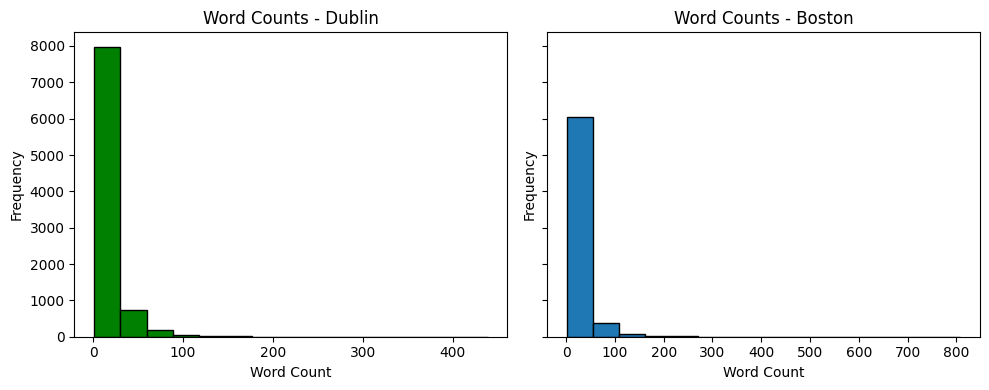

In [41]:
# Subplot for word counts frequencies.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True)

axes[0].hist(df_dublin_comments['word_count'], bins=15, edgecolor='black', color='green')
axes[0].set_title('Word Counts - Dublin')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_boston_comments['word_count'], bins=15, edgecolor='black')
axes[1].set_title('Word Counts - Boston')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

#### Insight:

For both datasets, the distribution is right-skewed, being the vast majority of comments shorter than 50 words in length. 

#### Polarity

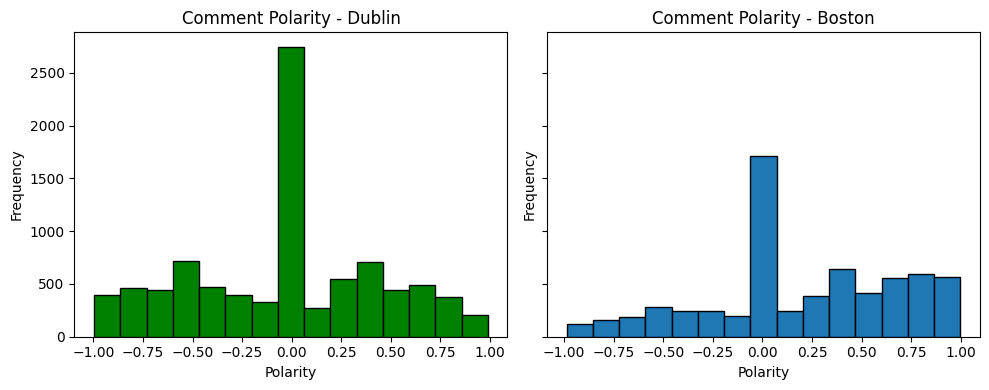

In [42]:
# Subplot for polarity frequencies.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True)

axes[0].hist(df_dublin_comments['comment_polarity'], bins=15, edgecolor='black', color='green')
axes[0].set_title('Comment Polarity - Dublin')
axes[0].set_xlabel('Polarity')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_boston_comments['comment_polarity'], bins=15, edgecolor='black')
axes[1].set_title('Comment Polarity - Boston')
axes[1].set_xlabel('Polarity')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

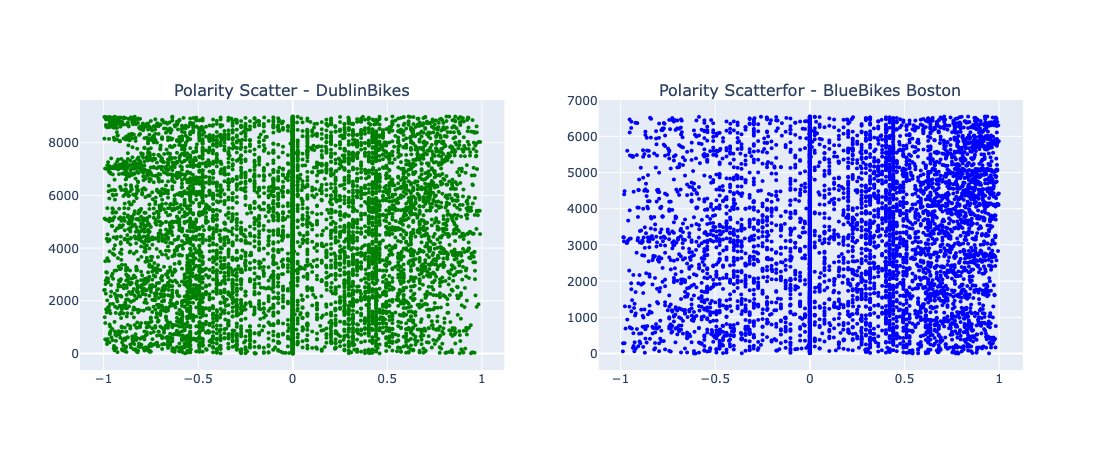

In [43]:
scatter = make_subplots(rows=1, cols=2 ,subplot_titles=('Polarity Scatter - DublinBikes', 'Polarity Scatterfor - BlueBikes Boston'))

# Polarity distribution for Dublink=Bikes.
scatter.add_trace(go.Scatter(x=df_dublin_comments['comment_polarity'], 
                             y=df_dublin_comments.index,
                             mode="markers",
                             marker=dict(color='green', size=4),
                             name = 'DublinBikes'), row=1, col=1 )


# Polarity distribution for BlueBikes Boston.
scatter.add_trace(go.Scatter(x=df_boston_comments['comment_polarity'],
                             y=df_boston_comments.index, 
                             mode="markers",
                             marker=dict(color='blue', size=4),
                             name = "BlueBikes Boston"),
                             row=1, col=2)

              
scatter.update_layout(height=450, width=900,showlegend=False)
scatter.show()

# Font: adapted from https://www.researchgate.net/figure/Scatter-Plot-of-Polarity-and-Subjectivity_fig3_352571788

#### Insights:

In both datasets the majority of comments have a polarity centered in between -0.025 and 0.25, indicating neutrality. DublinBikes dataset appears to have a fairly similar pattern when comparing negative x positive polarities, showing a considerabe peak at around -0.5 and 0.05. BlueBikes Boston dataset shows a general similar pattern, however, it presents a tendency to moderately positive sentiments with a peak in between 0.25 and 0.50 and a slight crescent towards the right.

#### Subjectivity

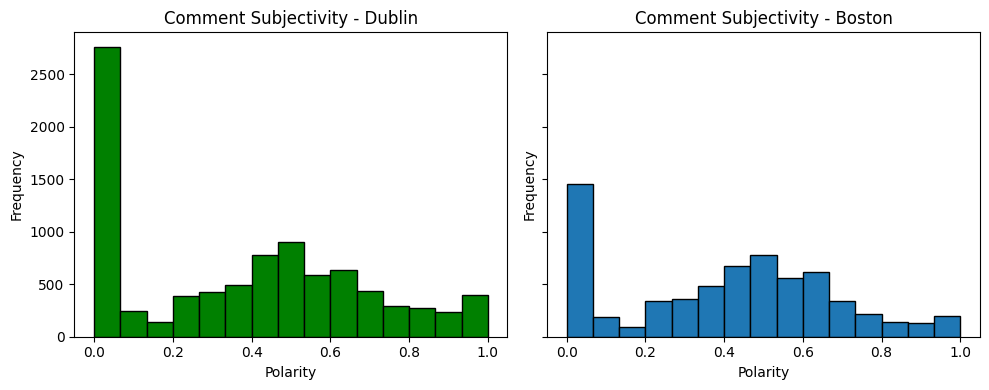

In [44]:
# Subplot for subjectivity frequencies.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True)

axes[0].hist(df_dublin_comments['comment_subjectivity'], bins=15, edgecolor='black', color='green')
axes[0].set_title('Comment Subjectivity - Dublin')
axes[0].set_xlabel('Polarity')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_boston_comments['comment_subjectivity'], bins=15, edgecolor='black')
axes[1].set_title('Comment Subjectivity - Boston')
axes[1].set_xlabel('Polarity')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

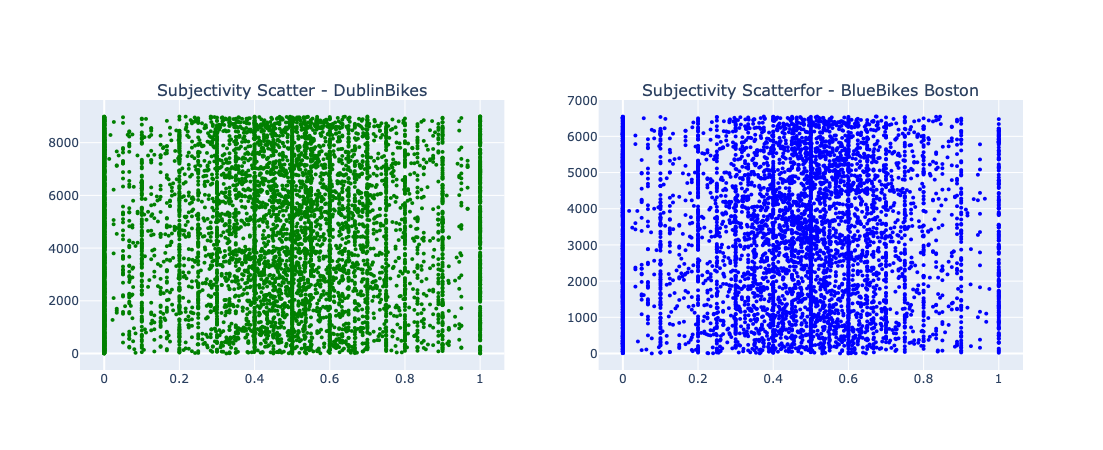

In [45]:
scatter = make_subplots(rows=1, cols=2 ,subplot_titles=('Subjectivity Scatter - DublinBikes', 'Subjectivity Scatterfor - BlueBikes Boston'))

# Subjectivity distribution for Dublink=Bikes.
scatter.add_trace(go.Scatter(x=df_dublin_comments['comment_subjectivity'], 
                             y=df_dublin_comments.index,
                             mode="markers",
                             marker=dict(color='green', size=4),
                             name = 'DublinBikes'), row=1, col=1 )


# Subjectivity distribution for BlueBikes Boston.
scatter.add_trace(go.Scatter(x=df_boston_comments['comment_subjectivity'],
                             y=df_boston_comments.index, 
                             mode="markers",
                             marker=dict(color='blue', size=4),
                             name = "BlueBikes Boston"),
                             row=1, col=2)

              
scatter.update_layout(height=450, width=900,showlegend=False)
scatter.show()

# Font: adapted from https://www.researchgate.net/figure/Scatter-Plot-of-Polarity-and-Subjectivity_fig3_352571788

#### Insights:

Both datasets follow a similar pattern, having the highest frequencies registered close to 0, which may suggest that most comments are naturally more objective and fact based. From 0.2 on, the graph shows a tendency to peak around the most neutral part of the spectrum, with a slight peak at the objective extremity. This pattern can also be in the scatter plot, where we have a cluster of points next to 0 and a 'normal like' distribution with a considerable clustering around the central area.

#### Comment score: Percentage Comparison

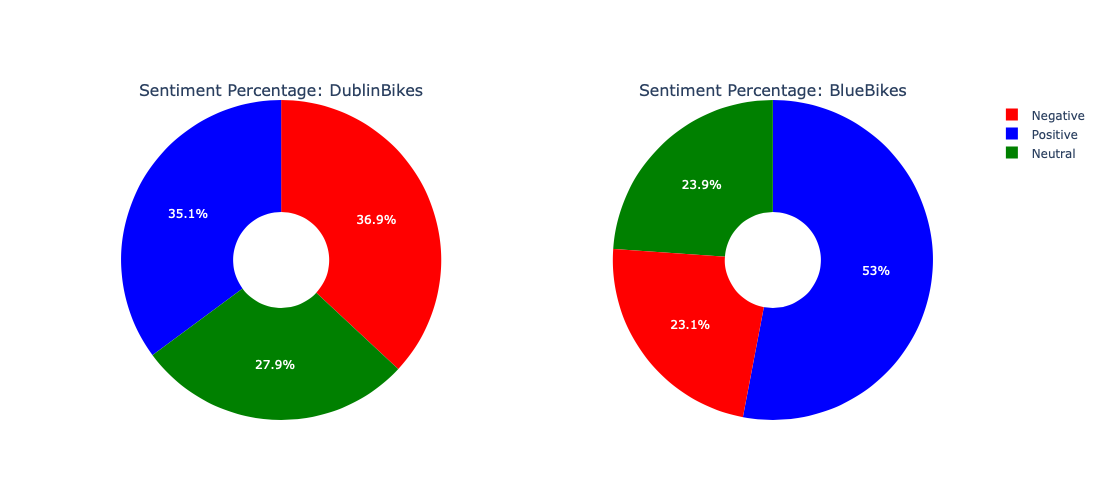

DublinBikes - Positive comments:  3160  ( 35.1 %)
DublinBikes - Negative comments:  3321  ( 36.9 %)
DublinBikes - Neutral comments:  2513  ( 27.9 %)
BlueBikes - Positive comments:  3473  ( 53.0 %)
BlueBikes - Negative comments:  1513  ( 23.1 %)
BlueBikes - Neutral comments:  1563  ( 23.9 %)


In [46]:
# Percentage

dublin_pos_comments_per = round((dublin_pos_comments / total_dublin_comments)*100, 1)
dublin_neg_comments_per = round((dublin_neg_comments / total_dublin_comments)*100, 1)
dublin_neu_comments_per = round((dublin_neu_comments / total_dublin_comments)*100, 1)


boston_pos_comments_per = round((boston_pos_comments / total_boston_comments)*100, 1)
boston_neg_comments_per = round((boston_neg_comments / total_boston_comments)*100, 1)
boston_neu_comments_per = round((boston_neu_comments / total_boston_comments)*100, 1)



#Creating pizza pie graphs for displaying percentages.

fig_pizza = make_subplots(rows=1, cols=2 ,subplot_titles=('Sentiment Percentage: DublinBikes', 'Sentiment Percentage: BlueBikes'), 
                          specs= [[{'type': 'domain'}, {'type': 'domain'}]]) # Obs: Pizza pies require a 'domain' subplot type.

fig_pizza_dublin = go.Pie( labels= ['Positive', 'Negative', 'Neutral'],
                           values = [dublin_pos_comments_per, dublin_neg_comments_per, dublin_neu_comments_per],
                           hole=.3,
                         marker=dict(colors=['blue', 'red', 'green']),
                          name="DublinBikes")

fig_pizza_boston = go.Pie( labels= ['Positive', 'Negative', 'Neutral'],
                       	values = [boston_pos_comments_per, boston_neg_comments_per, boston_neu_comments_per],
                       	hole=.3)

fig_pizza.add_trace(fig_pizza_dublin, row=1, col=1)
fig_pizza.add_trace(fig_pizza_boston, row=1, col=2)

fig_pizza.update_layout(height=500, width=1000, showlegend=True)
fig_pizza.show()

# Printing

print('DublinBikes - Positive comments: ', dublin_pos_comments,' (',dublin_pos_comments_per,'%)')
print('DublinBikes - Negative comments: ', dublin_neg_comments,' (',dublin_neg_comments_per,'%)')
print('DublinBikes - Neutral comments: ', dublin_neu_comments,' (',dublin_neu_comments_per,'%)')

print('BlueBikes - Positive comments: ', boston_pos_comments,' (',boston_pos_comments_per,'%)')
print('BlueBikes - Negative comments: ', boston_neg_comments,' (',boston_neg_comments_per,'%)')
print('BlueBikes - Neutral comments: ', boston_neu_comments,' (',boston_neu_comments_per,'%)')

# Font: adapted from: ps://medium.com/turing-talks/como-fazer-uma-análise-de-sentimentos-com-vader-21bbe3f3e38d

#### Insights:

For DublinBikes, the percentage of labels are considerably similar when it comes to negative and positive scores, showing a difference of almost 10% in relation to neutral scores. On the other hand, BlueBikes Boston percentage of positive scores are considerably higher than negative and neutral scores, by a difference of around 30%.

### Statistical Insights (DublinBikes and BlueBikes Boston Comments)

#### Descriptive Statistics

In [47]:
# Method .describe

df_dublin_comments.describe()

word_count  comment_polarity  comment_subjectivity
count  8994.000000       8994.000000           8994.000000
mean     14.682789         -0.025779              0.367455
std      19.553233          0.476575              0.308789
min       1.000000         -0.997000              0.000000
25%       4.000000         -0.401900              0.000000
50%       9.000000          0.000000              0.400000
75%      18.000000          0.318200              0.600000
max     439.000000          0.990500              1.000000

##### Conclusion:

- The descriptive statistics shows  that most comments are relatively short in length, with the 75th percentile showing that they have 18 words or less. The word count has a significant variation, with a standard deviation of 19.55 words.
- The polarity distribution indicates a neutral median polarity, with a good balance between positive and negative polarity. There is a significant distribution between positive and negative comments, with aslight tendency to negativity.
- The analysis shows a significant portion of objective comments (25th percentile = 0.0) and a median surrounding neutrality.

In [48]:
# Method .describe

df_boston_comments.describe()

word_count  comment_polarity  comment_subjectivity
count  6549.000000       6549.000000           6549.000000
mean     21.131318          0.199100              0.396165
std      30.182334          0.484506              0.278177
min       1.000000         -0.988000              0.000000
25%       6.000000          0.000000              0.128571
50%      13.000000          0.153100              0.433333
75%      26.000000          0.624900              0.600000
max     808.000000          0.998000              1.000000

##### Conclusion:

- The word count is skewed, presenting a standard deviation of 30.1, which is considerably higher than the mean of 18 words.This skewness can also be demonstrated by the maximum value which is much higher than the 75th percentile.
- Polarity values tend to be more neutral, leaning slightly towards positive sentiments even tough the wide range in standard deviation suggests a high variability of opinions.
- Subjectivity also tends to be more objective.

#### Addtional vizualisation: Blox Plots

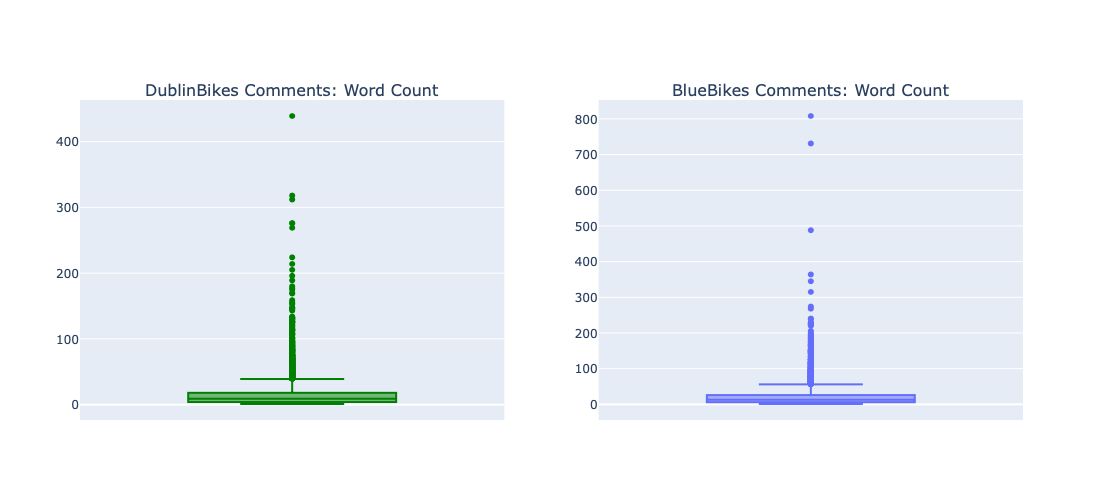

In [51]:
# Making subplots and plotting. 

fig_polarity_box = make_subplots(rows=1, cols=2, subplot_titles=('DublinBikes Comments: Word Count', 'BlueBikes Comments: Word Count'))
 

dublin_fig_polarity_box = px.box(df_dublin_comments, 
                                 y="word_count", 
                                 title="Box Plot: Polarity for DublinBikes", 
                                 color_discrete_sequence=['green'])

for trace in dublin_fig_polarity_box['data']:
    fig_polarity_box.add_trace(trace, row=1, col=1)

boston_fig_polarity_box = px.box(df_boston_comments, 
                                 y="word_count", 
                                 title="Box Plot: of Polarity for BlueBikes Boston")

for trace in boston_fig_polarity_box['data']:
    fig_polarity_box.add_trace(trace, row=1, col=2)

fig_polarity_box.update_layout(height=500, width=1000, showlegend=False)
fig_polarity_box.show()


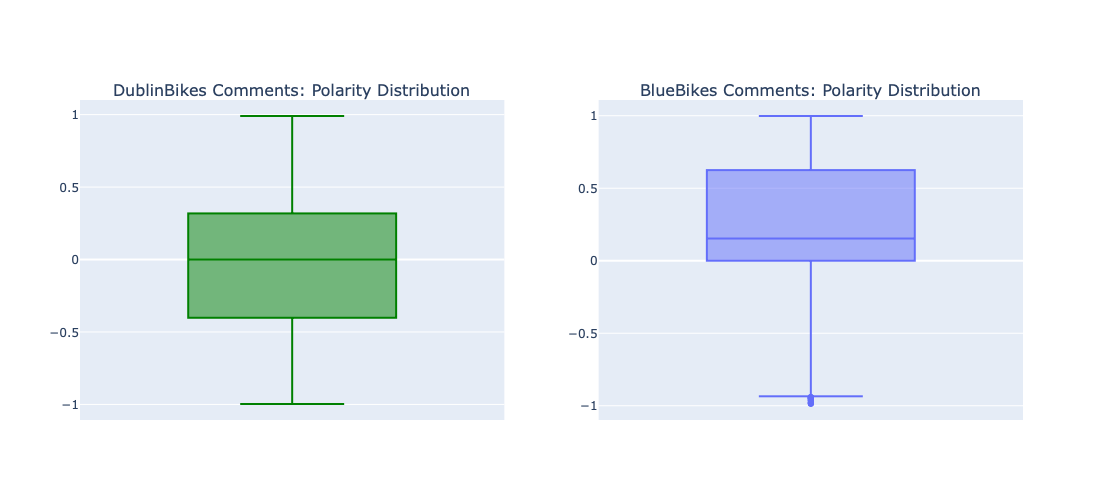

In [52]:
# Making subplots and plotting. 

fig_polarity_box = make_subplots(rows=1, cols=2, subplot_titles=('DublinBikes Comments: Polarity Distribution', 'BlueBikes Comments: Polarity Distribution'))
 

dublin_fig_polarity_box = px.box(df_dublin_comments, 
                                 y="comment_polarity", 
                                 title="Box Plot: Polarity for DublinBikes", 
                                 color_discrete_sequence=['green'])

for trace in dublin_fig_polarity_box['data']:
    fig_polarity_box.add_trace(trace, row=1, col=1)

boston_fig_polarity_box = px.box(df_boston_comments, 
                                 y="comment_polarity", 
                                 title="Box Plot: of Polarity for BlueBikes Boston")

for trace in boston_fig_polarity_box['data']:
    fig_polarity_box.add_trace(trace, row=1, col=2)

fig_polarity_box.update_layout(height=500, width=1000, showlegend=False)
fig_polarity_box.show()


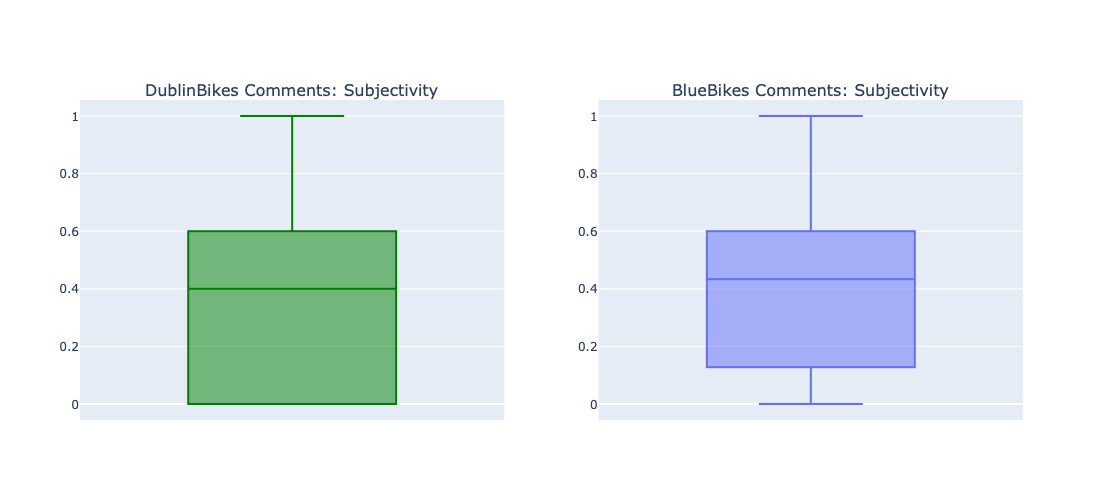

In [53]:
# Making subplots and plotting. 

fig_polarity_box = make_subplots(rows=1, cols=2, subplot_titles=('DublinBikes Comments: Subjectivity', 'BlueBikes Comments: Subjectivity'))
 

dublin_fig_polarity_box = px.box(df_dublin_comments, 
                                 y="comment_subjectivity", 
                                 title="Box Plot: Polarity for DublinBikes", 
                                 color_discrete_sequence=['green'])

for trace in dublin_fig_polarity_box['data']:
    fig_polarity_box.add_trace(trace, row=1, col=1)

boston_fig_polarity_box = px.box(df_boston_comments, 
                                 y="comment_subjectivity", 
                                 title="Box Plot: of Polarity for BlueBikes Boston")

for trace in boston_fig_polarity_box['data']:
    fig_polarity_box.add_trace(trace, row=1, col=2)

fig_polarity_box.update_layout(height=500, width=1000, showlegend=False)
fig_polarity_box.show()


#### Calculating the Correlation Between Variables

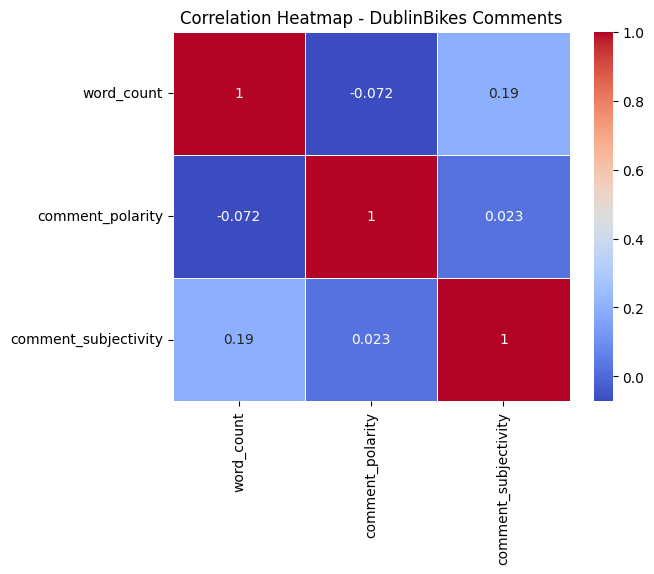

DublinBikes Corr: 
                       word_count  comment_polarity  comment_subjectivity
word_count              1.000000         -0.072097              0.194732
comment_polarity       -0.072097          1.000000              0.022515
comment_subjectivity    0.194732          0.022515              1.000000


In [54]:
dublin_comments_corr =df_dublin_comments[['word_count', 'comment_polarity', 'comment_subjectivity']].corr()
boston_comments_corr = df_boston_comments[['word_count', 'comment_polarity', 'comment_subjectivity']].corr()

# Subplot for correlation between variables in both datasets.

sns.heatmap(dublin_comments_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap - DublinBikes Comments')
plt.show()

print('DublinBikes Corr: \n', dublin_comments_corr)

##### Conclusion: 

- Word Count and Comment Polarity (-0.0721): Very weak negative correlation between variables, which means that length does not significantly affect the sentiment of comments.
- Word Count and Comment Subjectivity (0.1947): Positive but very weak correlation. In this dataset, longer comments tend to be more subjective. That may suggest that the more people write, the more subjective their comments tend to be.
- Comment Polarity and Comment Subjectivity (0.0225): Very close to zero. This correlation suggests that the sentiment of a comment does not affect their subjectivity.

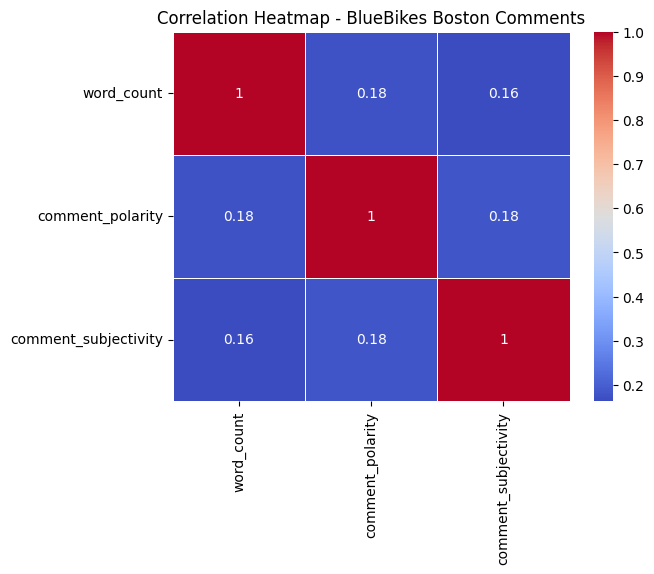

BlueBikes Boston Corr: 
                       word_count  comment_polarity  comment_subjectivity
word_count              1.000000          0.175438              0.162890
comment_polarity        0.175438          1.000000              0.179645
comment_subjectivity    0.162890          0.179645              1.000000


In [55]:
sns.heatmap(boston_comments_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap - BlueBikes Boston Comments')
plt.show()

print('BlueBikes Boston Corr: \n', boston_comments_corr)

##### Conclusion: 

There is a weak positive correlation between variables, which means that longer comments have a slight tendency to be more positive.

- Word Count and Comment Polarity (0.1754): The Correlation is positive but weak. The results suggest that longer comments tend to be slightly more positive. That means that users tend to be more inclined to write slightly more positive comments the more they write.
- Word Count and Comment Subjectivity (0.1629): The correlation is also positive but weak. As the previous analysis, the results suggest that longer comments tend to be more subjective.
- Comment Polarity and Comment Subjectivity (0.1796): The Correlation is positive but weak. There is a slight tendency that more positive comments tend to express more subjective features.
